### Introduction / Objective
→ "We are predicting customer lifetime value to help target marketing efforts."

In [1]:
import pandas as pd
df = pd.read_csv("WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv")


## Load and Explore the Data
→ Import, read the CSV, peek at data

In [2]:
import datetime as dt
snapshot = pd.to_datetime(df["Effective To Date"]).max() + dt.timedelta(days=1)
rfm = df.groupby("Customer").agg({
    "Effective To Date": lambda x: (snapshot - pd.to_datetime(x).max()).days,
    "Total Claim Amount": ["count", "mean"]
})
rfm.columns = ["Recency", "Frequency", "AOV"]
rfm.reset_index(inplace=True)


<ipython-input-2-3217942fdd8f>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  snapshot = pd.to_datetime(df["Effective To Date"]).max() + dt.timedelta(days=1)


## Feature Engineering (RFM)
→ Recency, Frequency, AOV

In [4]:
# Merge RFM with the original dataframe to get Customer Lifetime Value (CLV)
rfm = rfm.merge(df[['Customer', 'Customer Lifetime Value']], on='Customer', how='left')

# Define X (features) and y (target)
X = rfm[['Recency', 'Frequency', 'AOV']]
y = rfm['Customer Lifetime Value']


## Model Building (XGBoost)
→ Train/test split, fit the model

In [5]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Evaluation
→ MAE, prediction check

In [7]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")


MAE: 4409.72


In [11]:
y.describe()


,Customer Lifetime Value
count,9134.000000
mean,8004.940475
std,6870.967608
min,1898.007675
25%,3994.251794
50%,5780.182197
75%,8962.167041
max,83325.381190


In [14]:
# Make sure X is still defined
rfm['Predicted_LTV'] = model.predict(X)


In [15]:
# Segment customers into quartiles based on predicted LTV
rfm['Segment'] = pd.qcut(rfm['Predicted_LTV'], q=4, labels=['Low', 'Medium', 'High', 'VIP'])


In [16]:
rfm[['Customer', 'Predicted_LTV', 'Segment']].to_csv("ltv_predictions.csv", index=False)


In [17]:
import joblib

# Save the model to a file
joblib.dump(model, 'ltv_model.pkl')


['ltv_model.pkl']

In [18]:
loaded_model = joblib.load('ltv_model.pkl')


### Visualizations
→ Segment bar chart, scatterplot



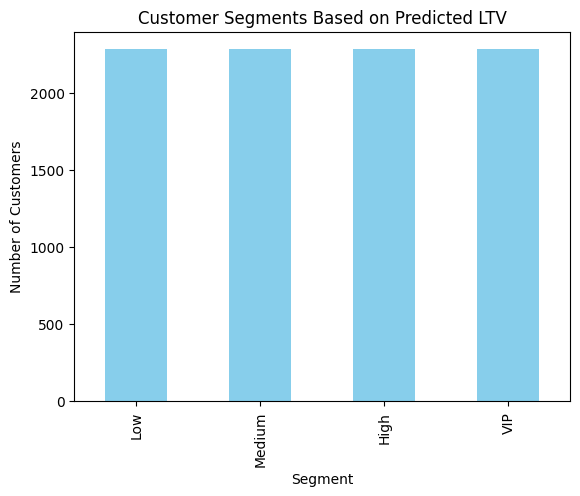

In [19]:
import matplotlib.pyplot as plt

rfm['Segment'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Customer Segments Based on Predicted LTV')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()


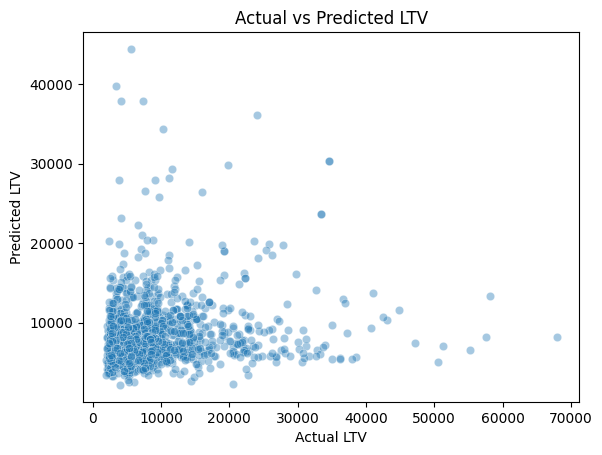

In [20]:
import seaborn as sns

sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.xlabel('Actual LTV')
plt.ylabel('Predicted LTV')
plt.title('Actual vs Predicted LTV')
plt.show()


## *Customer Segment Distribution (Bar Chart)

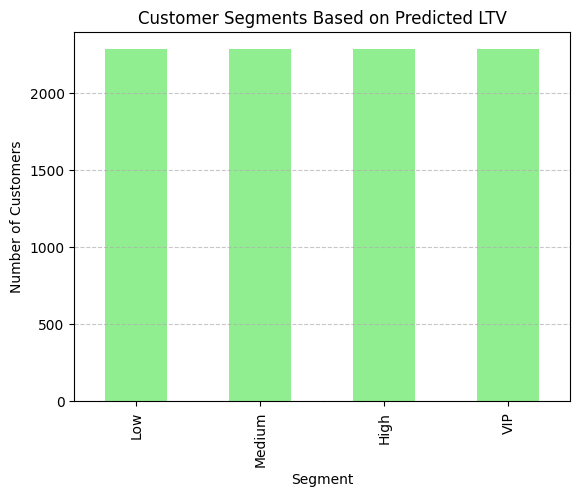

In [21]:
import matplotlib.pyplot as plt

rfm['Segment'].value_counts().sort_index().plot(kind='bar', color='lightgreen')
plt.title('Customer Segments Based on Predicted LTV')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Predicted LTV Distribution (Histogram)

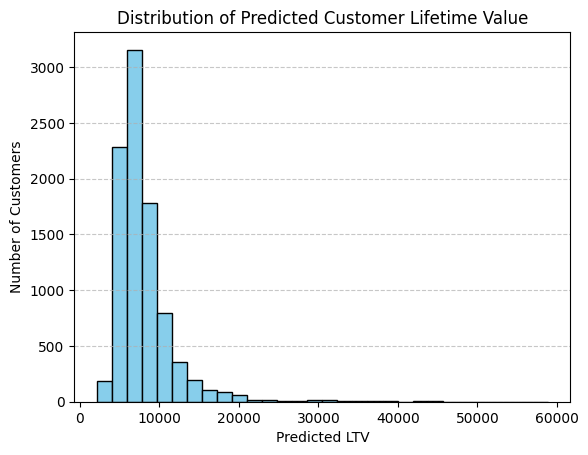

In [22]:
plt.hist(rfm['Predicted_LTV'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Customer Lifetime Value')
plt.xlabel('Predicted LTV')
plt.ylabel('Number of Customers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<ipython-input-23-fcaa4ad73bfe>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segment', y='Predicted_LTV', data=rfm, palette='pastel')


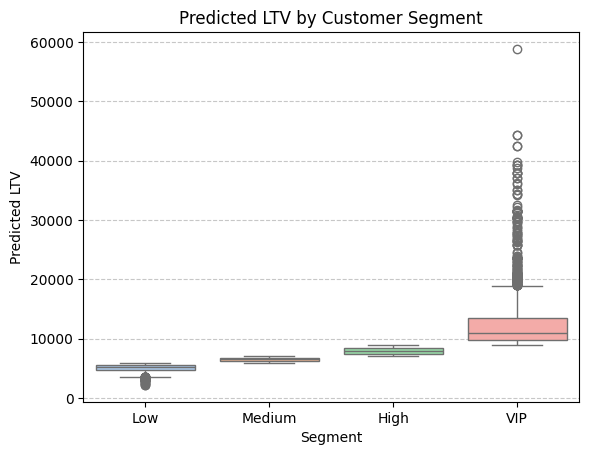

In [23]:
import seaborn as sns

sns.boxplot(x='Segment', y='Predicted_LTV', data=rfm, palette='pastel')
plt.title('Predicted LTV by Customer Segment')
plt.xlabel('Segment')
plt.ylabel('Predicted LTV')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


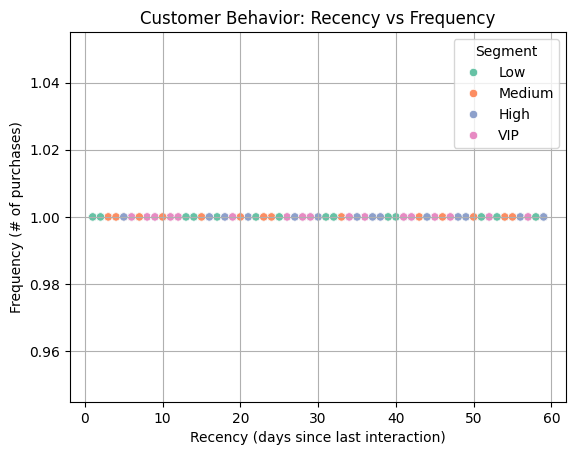

In [24]:
sns.scatterplot(x='Recency', y='Frequency', hue='Segment', data=rfm, palette='Set2')
plt.title('Customer Behavior: Recency vs Frequency')
plt.xlabel('Recency (days since last interaction)')
plt.ylabel('Frequency (# of purchases)')
plt.grid(True)
plt.show()


In [25]:
plt.savefig('plot_name.png', dpi=300)


<Figure size 640x480 with 0 Axes>

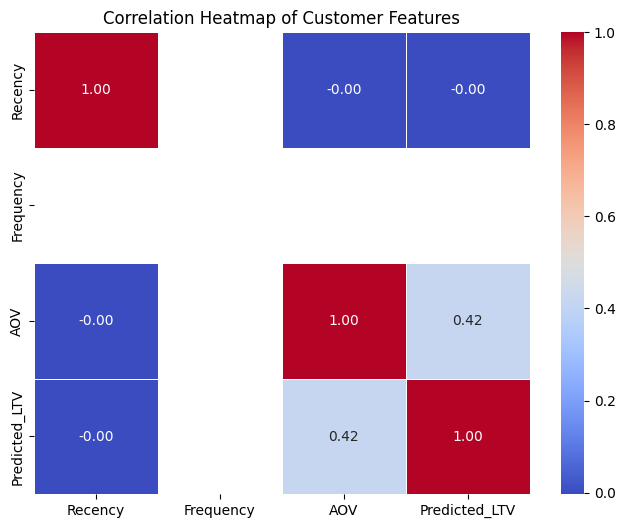

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric features to include
corr_features = rfm[['Recency', 'Frequency', 'AOV', 'Predicted_LTV']]

# Calculate correlation matrix
corr_matrix = corr_features.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Customer Features')
plt.show()
